#Assignment 1: Decoding 20 Years of Amazon’s Shareholder Letters Using Gen AI

**Introduction:**

Amazon’s annual shareholder letters are a gold mine of information on strategic vision, evolving risks, and leadership tone. In this assignment, you will apply Large Language Models (LLMs) to analyze the past 20 years of Amazon’s shareholder letters, extracting key risk themes, strategy themes, annual summaries, and sentiment. You will then analyze trends and present your findings, gaining hands-on experience in prompt engineering, NLP driven document analysis, and business storytelling with AI.

# Import Libraries:

In [ ]:
# Install dependencies (run once)
!pip install PyPDF2 transformers bitsandbytes --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.4 MB/s eta 0:00:00


In [ ]:
!pip install tqdm --quiet

In [ ]:
# Mount Google Drive & imports
from google.colab import drive
drive.mount('/content/drive')

import re
from PyPDF2 import PdfReader
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    pipeline
)
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

# Helper for display
import textwrap

Mounted at /content/drive


In [ ]:
# ------------------------------------------------------------
# 2. Check hardware availability
# ------------------------------------------------------------
print("Checking hardware...")  # Print status message
print("GPU Available:", torch.cuda.is_available())  # Check if CUDA GPU is available

if torch.cuda.is_available():  # If GPU is available
    print("GPU Name:", torch.cuda.get_device_name(0))  # Print GPU model name
    print("GPU Memory:", torch.cuda.get_device_properties(0).total_memory / 1024**3, "GB")  # Convert bytes to GB
    device = "cuda"  # Set device to GPU
    dtype = torch.float16  # Use half precision (16-bit) to save memory on GPU
else:  # If no GPU available
    print("\n⚠️  No GPU detected! Running on CPU.")  # Warning message
    print("To enable GPU in Colab:")  # Instructions for enabling GPU
    print("1. Go to Runtime → Change runtime type")
    print("2. Select GPU as Hardware accelerator")
    print("3. Click Save and restart runtime")
    device = "cpu"  # Set device to CPU
    dtype = torch.float32  # Use full precision (32-bit) on CPU for stability

Checking hardware...
GPU Available: True
GPU Name: Tesla T4
GPU Memory: 14.74127197265625 GB


# Extract PDF Text:

In [ ]:
def extract_text_from_pdf(path):
    reader = PdfReader(path)
    pages = []
    for i, page in enumerate(reader.pages, start=1):
        text = page.extract_text() or ""
        pages.append(text.strip())
        print(f"Extracted page {i}/{len(reader.pages)}")
    # join with double–newline between pages
    return "\n\n".join(pages)

In [ ]:
letter_data = []

for year in range(2005, 2025):
    PDF_PATH = f'/content/drive/My Drive/GenAI/Assignment_1/Letters/{year}.pdf'
    print(f"Extracting {year} Shareholder Letter...")

    full_text = extract_text_from_pdf(PDF_PATH)
    print("\n=== Document Preview ===")
    print(textwrap.fill(full_text[:500], width=80), "…")

    letter_data.append({'letter': full_text, 'year': year})

Extracting 2005 Shareholder Letter...
Extracted page 1/5
Extracted page 2/5
Extracted page 3/5
Extracted page 4/5
Extracted page 5/5

=== Document Preview ===
To our shareholders: Many of the important decisions we make at Amazon.com can
be made with data. There is a right answer or a wrong answer, a better answer or
a worse answer, and math tells us which is which. These are our favoritekinds of
decisions. Opening a new fulfillment center is an example. We use history from
our existing fulfillment network to estimate seasonal peaks and to model
alternatives for new capacity. We look at anticipated product mix,including
product dimensions and weight, …
Extracting 2006 Shareholder Letter...
Extracted page 1/5
Extracted page 2/5
Extracted page 3/5
Extracted page 4/5
Extracted page 5/5

=== Document Preview ===
To our shareholders: At Amazon’s current scale, planting seeds that will grow
into meaningful new businesses takes some discipline, a bit of patience, and a
nurturing culture. Our 

In [ ]:
df = pd.DataFrame(letter_data)

In [ ]:
df.shape

(20, 2)

In [ ]:
df.sample(3)

,letter,year
15,To our shareowners:\nIn Amazon’s 1997 letter t...,2020
1,To our shareholders:\nAt Amazon’s current scal...,2006
11,"“Jeff, what does Day 2 look like?”\nThat’s a q...",2016


# Clean Text:

In [ ]:
df['letter'] = df['letter'].apply(lambda x: x.split("1997 LETTER TO SHAREHOLDERS", 1)[0])
df['letter'] = df['letter'].apply(lambda x: re.sub('\s', ' ', x))
df['letter'] = df['letter'].apply(lambda x: re.sub('\n', ' ', x))

In [ ]:
df['letter'][0]

'To our shareholders: Many of the important decisions we make at Amazon.com can be made with data. There is a right answer or a wrong answer, a better answer or a worse answer, and math tells us which is which. These are our favoritekinds of decisions. Opening a new fulfillment center is an example. We use history from our existing fulfillment network to estimate seasonal peaks and to model alternatives for new capacity. We look at anticipated product mix,including product dimensions and weight, to decide how much space we need and whether we need a facility forsmaller “sortable” items or for larger items that usually ship alone. To shorten delivery times and reduceoutbound transportation costs, we analyze prospective locations based on proximity to customers, transportationhubs, and existing facilities. Quantitative analysis improves the customer’s experience and our cost structure. Similarly, most of our inventory purchase decisions can be numerically modeled and analyzed. We want pr

In [ ]:
df["themes"] = ""
df["risks"] = ""
df["sentiment"] = ""
df["summary"] = ""

In [ ]:
df

,letter,year,themes,risks,sentiment,summary
0,To our shareholders: Many of the important dec...,2005,,,,
1,To our shareholders: At Amazon’s current scale...,2006,,,,
2,"To our shareowners: November 19, 2007, was a s...",2007,,,,
3,To our shareowners: In this turbulent global e...,2008,,,,
4,To our shareowners: The financial results for ...,2009,,,,
5,"To our shareowners: Random forests, naïve Baye...",2010,,,,
6,To our shareowners: The Power of Invention “To...,2011,,,,
7,To our shareowners: As regular readers of this...,2012,,,,
8,To our shareowners: I’m so proud of what all t...,2013,,,,
9,To our shareowners: A dreamy business offering...,2014,,,,


# Import Model:

In [ ]:
import os
from huggingface_hub import login
from getpass import getpass  # Secure input without echoing token

# Prompt user to enter Hugging Face token (invisible while typing)
hf_token = getpass("🔐 Enter your Hugging Face token: ")

# Login securely using the token
login(token=hf_token, add_to_git_credential=False)

# Store token in environment for downstream usage
os.environ["HF_TOKEN"] = hf_token

🔐 Enter your Hugging Face token: ··········


In [ ]:
import time

# Load tokenizer and quantized model
model_id = "google/gemma-2-2b-it"

tokenizer = AutoTokenizer.from_pretrained(model_id, token=hf_token)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto" if device == "cuda" else None,
    load_in_4bit=True,
    token=hf_token
)

model.eval()  # Set model to inference mode

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear4bit(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2304, bias=False)
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear4bit(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_

# Define Prompts:

In [ ]:
# We define `prompt` as a plain Python format-template (no leading `f`).
# Inside this template, we use `{{` and `}}` to emit literal `{` and `}` characters,
# because a single `{` or `}` would be interpreted by `.format()` as a placeholder.

fs_prompt = """
You are an expert financial analyst that excels at extracting key themes, risks, sentiment, and summaries from Amazon shareholder letters. Return ONLY a valid JSON object with these keys: "sentiment", "themes", "risks", "summary".
Do NOT include any explanations, markdown, backticks, labels, or extra text.

# Example 1 (positive case)
Context:
Publishing reached new heights. Revenue grew. Fulfillment efficiency increased. Membership renewal rates increased.

Task:
Analyze the shareholder letter and return:
- "sentiment": overall tone (positive, neutral, or negative)
- "themes": exactly 3 key themes
- "risks": exactly 3 key risks or challenges
- "summary": a one-paragraph summary (< 100 words)

Keep each risk and theme a couple of words each, but meaningful in relation to shareholder interests.

Respond ONLY with a valid JSON object:

{{
  "sentiment": "positive",
  "themes": ["revenue growth", "operational efficiency", "customer engagement"],
  "risks": ["cloud infrastructure limitations", "streaming competition", "fulfillment limitations"],
  "summary": "Amazon experienced growth in several services and increased operational efficiency."
}}

# Example 2 (negative case)
Context:
Retail revenue declined. Layoffs impacted several divisions. Growth slowed due to competition. Membership rates decreased.

Task:
Analyze the shareholder letter and return:
- "sentiment": overall tone (positive, neutral, or negative)
- "themes": exactly 3 key themes
- "risks": exactly 3 key risks or challenges
- "summary": a one-paragraph summary (< 100 words)

Keep each risk and theme a couple of words each, but meaningful in relation to shareholder interests.

Respond ONLY with a valid JSON object:

{{
  "sentiment": "negative",
  "themes": ["retail slowdown", "staffing", "cloud competition"],
  "risks": ["revenue decline", "reduced staffing", "growing competition"],
  "summary": "Revenue decline and growing competition triggered layoffs and slowing growth."
}}

# Example 3 (neutral case)
Context:
Revenue remained flat. Investments in emerging technologies including AI continued. Service growth stabilized.

Task:
Analyze the shareholder letter and return:
- "sentiment": overall tone (positive, neutral, or negative)
- "themes": exactly 3 key themes
- "risks": exactly 3 key risks or challenges
- "summary": a one-paragraph summary (< 100 words)

Keep each risk and theme a couple of words each, but meaningful in relation to shareholder interests.

Respond ONLY with a valid JSON object:

{{
  "sentiment": "neutral",
  "themes": ["stability", "investments", "equipment"],
  "risks": ["market fluctuations", "uncertain ROIs", "slowing interest"],
  "summary": "Amazon maintained stable performance while continuing to invest in future growth."
}}

Context:
{context}

Task:
Analyze the shareholder letter and return:
- "sentiment": overall tone (positive, neutral, or negative)
- "themes": exactly 3 key themes
- "risks": exactly 3 key risks or challenges
- "summary": a one-paragraph summary (< 100 words)

Keep each risk and theme a couple of words each, but meaningful in relation to shareholder interests.

Respond ONLY with a valid JSON object containing those keys.
"""

In [ ]:
zs_prompt = """
You are an expert financial analyst that excels at extracting key details, themes, and trends from Amazon shareholder letters. Your job is to extract and summarize important information in a structured format. Return ONLY a syntactically valid JSON object with these keys: "sentiment", "themes", "risks", "summary".
Do NOT include any explanations, markdown, backticks, labels, or extra text.

Task:
Analyze the shareholder letter and return:
- "sentiment": overall tone (positive, neutral, or negative)
- "themes": EXACTLY 3 key themes.
- "risks": EXACTLY 3 key risks or challenges.
- "summary": a one-paragraph summary of less than 100 words.

ALWAYS output EXACTLY 3 key themes in the "theme" key and EXACTLY 3 key risks in the "risks" key, ALWAYS include a summary of less than 100 words in the "summary" key, and ALWAYS include sentiment (positive, negative, or neutral) in the "sentiment" key.

Do not ouput more than 3 themes and 3 risks and keep each risk and theme a couple of words each, but meaningful in relation to shareholder interests.

Respond ONLY with a valid JSON object with "sentiment", "themes", "risks", and "summary" keys:

{{
  "sentiment": "sentiment",
  "themes": ["theme 1", "theme 2", "theme 3"],
  "risks": ["risk 1", "risk 2", "risk 3"],
  "summary": "summary"
}}

The letter is provided in the context below.

Context:
{context}
"""

## Prompt Tokens:

In [ ]:
# Assume `prompt` is your template string defined earlier (with {{…}} escapes and {context} placeholder)
#    If you want to see how many tokens the template itself consumes:
fs_template_text = fs_prompt  # no .format() here, we’re measuring the raw template
zs_template_text = zs_prompt

# Encode the template into token IDs (no special tokens added)
token_ids = tokenizer.encode(fs_template_text, add_special_tokens=False)
# Print the Few-Shot Token Count
print(f"Few-Shot Template Token Count: {len(token_ids)}")

# Encode the template into token IDs (no special tokens added)
token_ids = tokenizer.encode(zs_template_text, add_special_tokens=False)
# Print the Zero-Shot Token Count
print(f"Zero-Shot Template Token Count: {len(token_ids)}")

Few-Shot Template Token Count: 737
Zero-Shot Template Token Count: 351


In [ ]:
# Iterate through the DataFrame & Count tokens in Prompt + Letter Text:
for index, row in df.iterrows():
    token_ids = tokenizer.encode(row['letter'] + fs_prompt, add_special_tokens=False)
    print(f"Few-Shot Token Count {row['year']}: {len(token_ids)}")

    token_ids = tokenizer.encode(row['letter'] + zs_prompt, add_special_tokens=False)
    print(f"Zero-Shot Token Count {row['year']}: {len(token_ids)}")

    print()

Few-Shot Token Count 2005: 2138
Zero-Shot Token Count 2005: 1752

Few-Shot Token Count 2006: 1978
Zero-Shot Token Count 2006: 1592

Few-Shot Token Count 2007: 2262
Zero-Shot Token Count 2007: 1876

Few-Shot Token Count 2008: 2184
Zero-Shot Token Count 2008: 1798

Few-Shot Token Count 2009: 1979
Zero-Shot Token Count 2009: 1593

Few-Shot Token Count 2010: 2126
Zero-Shot Token Count 2010: 1740

Few-Shot Token Count 2011: 3227
Zero-Shot Token Count 2011: 2841

Few-Shot Token Count 2012: 2476
Zero-Shot Token Count 2012: 2090

Few-Shot Token Count 2013: 6435
Zero-Shot Token Count 2013: 6049

Few-Shot Token Count 2014: 4997
Zero-Shot Token Count 2014: 4611

Few-Shot Token Count 2015: 6048
Zero-Shot Token Count 2015: 5662

Few-Shot Token Count 2016: 3031
Zero-Shot Token Count 2016: 2645

Few-Shot Token Count 2017: 6477
Zero-Shot Token Count 2017: 6091

Few-Shot Token Count 2018: 4031
Zero-Shot Token Count 2018: 3645

Few-Shot Token Count 2019: 4775
Zero-Shot Token Count 2019: 4389

Few-Shot T

# Inference:

In [ ]:
fs_df = df.copy()
zs_df = df.copy()

In [ ]:
for i, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing Letter with Few-Shot Prompt..."):
    # 1) Extract the report text for this row
    context = row["letter"]

    # 2) Inject the dynamic context into your plain-text prompt template
    current_prompt = fs_prompt.format(context=context)

    # 3) Wrap it in a single “user” message, ready for chat‐style formatting
    messages = [{"role": "user", "content": current_prompt}]

    # 4) Apply Gemma’s chat template: this inserts <start_of_turn>user, <end_of_turn>, and <start_of_turn>model
    formatted_prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,             # keep it as a raw string
        add_generation_prompt=True  # append <start_of_turn>model so generation knows where to start
    )

    print(f"Formatted Prompt Token Count {row['year']}: {len(tokenizer.encode(formatted_prompt))}")

    # 5) Tokenize the fully formatted prompt and move tensors to the model’s device
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)
    input_len = inputs["input_ids"].shape[-1]  # remember how many prompt tokens

    # 6) Generate the model’s response in inference mode
    with torch.no_grad():
        output = model.generate(
            **inputs,                 # unpack input_ids, attention_mask, etc.
            max_new_tokens=500,       # max number of tokens to generate
            temperature=0.5,          # sampling temperature
            top_k=40,                 # top-k sampling
            top_p=0.9,                # nucleus sampling
            do_sample=True,           # enable stochastic sampling
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    # 7) Slice off the original prompt tokens to isolate just the generated tokens
    generated_tokens = output[0][input_len:]

    # 8) Decode the generated tokens into text, skipping any special tokens
    decoded = tokenizer.decode(generated_tokens, skip_special_tokens=True)

    fs_df.at[i, "llm_output"] = decoded.strip()

Processing Letter with Few-Shot Prompt...:   0%|          | 0/20 [00:00<?, ?it/s]

Formatted Prompt Token Count 2005: 2143


Processing Letter with Few-Shot Prompt...:   5%|▌         | 1/20 [00:09<02:59,  9.43s/it]

Formatted Prompt Token Count 2006: 1983


Processing Letter with Few-Shot Prompt...:  10%|█         | 2/20 [00:19<03:01, 10.09s/it]

Formatted Prompt Token Count 2007: 2267


Processing Letter with Few-Shot Prompt...:  15%|█▌        | 3/20 [00:31<02:59, 10.58s/it]

Formatted Prompt Token Count 2008: 2189


Processing Letter with Few-Shot Prompt...:  20%|██        | 4/20 [00:41<02:46, 10.38s/it]

Formatted Prompt Token Count 2009: 1984


Processing Letter with Few-Shot Prompt...:  25%|██▌       | 5/20 [00:50<02:29,  9.95s/it]

Formatted Prompt Token Count 2010: 2131


Processing Letter with Few-Shot Prompt...:  30%|███       | 6/20 [01:00<02:20, 10.03s/it]

Formatted Prompt Token Count 2011: 3232


Processing Letter with Few-Shot Prompt...:  35%|███▌      | 7/20 [01:13<02:21, 10.86s/it]

Formatted Prompt Token Count 2012: 2481


Processing Letter with Few-Shot Prompt...:  40%|████      | 8/20 [01:24<02:11, 10.92s/it]

Formatted Prompt Token Count 2013: 6440


Processing Letter with Few-Shot Prompt...:  45%|████▌     | 9/20 [01:41<02:22, 12.98s/it]

Formatted Prompt Token Count 2014: 5002


Processing Letter with Few-Shot Prompt...:  50%|█████     | 10/20 [01:58<02:20, 14.02s/it]

Formatted Prompt Token Count 2015: 6053


Processing Letter with Few-Shot Prompt...:  55%|█████▌    | 11/20 [02:17<02:20, 15.58s/it]

Formatted Prompt Token Count 2016: 3036


Processing Letter with Few-Shot Prompt...:  60%|██████    | 12/20 [02:28<01:54, 14.36s/it]

Formatted Prompt Token Count 2017: 6482


Processing Letter with Few-Shot Prompt...:  65%|██████▌   | 13/20 [02:47<01:49, 15.62s/it]

Formatted Prompt Token Count 2018: 4036


Processing Letter with Few-Shot Prompt...:  70%|███████   | 14/20 [02:59<01:27, 14.62s/it]

Formatted Prompt Token Count 2019: 4780


Processing Letter with Few-Shot Prompt...:  75%|███████▌  | 15/20 [03:16<01:16, 15.35s/it]

Formatted Prompt Token Count 2020: 5961


Processing Letter with Few-Shot Prompt...:  80%|████████  | 16/20 [03:33<01:03, 15.83s/it]

Formatted Prompt Token Count 2021: 6644


Processing Letter with Few-Shot Prompt...:  85%|████████▌ | 17/20 [03:51<00:49, 16.45s/it]

Formatted Prompt Token Count 2022: 7331


Processing Letter with Few-Shot Prompt...:  90%|█████████ | 18/20 [04:12<00:35, 17.85s/it]

Formatted Prompt Token Count 2023: 8000


Processing Letter with Few-Shot Prompt...:  95%|█████████▌| 19/20 [04:34<00:19, 19.19s/it]

Formatted Prompt Token Count 2024: 7298


Processing Letter with Few-Shot Prompt...: 100%|██████████| 20/20 [04:56<00:00, 14.84s/it]


In [ ]:
fs_df

,letter,year,themes,risks,sentiment,summary,llm_output
0,To our shareholders: Many of the important dec...,2005,,,,,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
1,To our shareholders: At Amazon’s current scale...,2006,,,,,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
2,"To our shareowners: November 19, 2007, was a s...",2007,,,,,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
3,To our shareowners: In this turbulent global e...,2008,,,,,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
4,To our shareowners: The financial results for ...,2009,,,,,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
5,"To our shareowners: Random forests, naïve Baye...",2010,,,,,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
6,To our shareowners: The Power of Invention “To...,2011,,,,,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
7,To our shareowners: As regular readers of this...,2012,,,,,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
8,To our shareowners: I’m so proud of what all t...,2013,,,,,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
9,To our shareowners: A dreamy business offering...,2014,,,,,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."


In [ ]:
for i, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing Letter with Zero-Shot Prompt..."):
    # 1) Extract the report text for this row
    context = row["letter"]

    # 2) Inject the dynamic context into your plain-text prompt template
    current_prompt = zs_prompt.format(context=context)

    # 3) Wrap it in a single “user” message, ready for chat‐style formatting
    messages = [{"role": "user", "content": current_prompt}]

    # 4) Apply Gemma’s chat template: this inserts <start_of_turn>user, <end_of_turn>, and <start_of_turn>model
    formatted_prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,             # keep it as a raw string
        add_generation_prompt=True  # append <start_of_turn>model so generation knows where to start
    )

    print(f" Formatted Prompt Token Count {row['year']}: {len(tokenizer.encode(formatted_prompt))}")

    # 5) Tokenize the fully formatted prompt and move tensors to the model’s device
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)
    input_len = inputs["input_ids"].shape[-1]  # remember how many prompt tokens

    # 6) Generate the model’s response in inference mode
    with torch.no_grad():
        output = model.generate(
            **inputs,                 # unpack input_ids, attention_mask, etc.
            max_new_tokens=500,       # max number of tokens to generate
            temperature=0.1,          # sampling temperature
            top_k=40,                 # top-k sampling
            top_p=0.9,                # nucleus sampling
            do_sample=True,           # enable stochastic sampling
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    # 7) Slice off the original prompt tokens to isolate just the generated tokens
    generated_tokens = output[0][input_len:]

    # 8) Decode the generated tokens into text, skipping any special tokens
    decoded = tokenizer.decode(generated_tokens, skip_special_tokens=True)

    zs_df.at[i, "llm_output"] = decoded.strip()

Processing Letter with Zero-Shot Prompt...:   0%|          | 0/20 [00:00<?, ?it/s]

 Formatted Prompt Token Count 2005: 1756


Processing Letter with Zero-Shot Prompt...:   5%|▌         | 1/20 [00:11<03:42, 11.73s/it]

 Formatted Prompt Token Count 2006: 1596


Processing Letter with Zero-Shot Prompt...:  10%|█         | 2/20 [00:22<03:21, 11.19s/it]

 Formatted Prompt Token Count 2007: 1880


Processing Letter with Zero-Shot Prompt...:  15%|█▌        | 3/20 [00:34<03:17, 11.64s/it]

 Formatted Prompt Token Count 2008: 1802


Processing Letter with Zero-Shot Prompt...:  20%|██        | 4/20 [00:47<03:12, 12.03s/it]

 Formatted Prompt Token Count 2009: 1597


Processing Letter with Zero-Shot Prompt...:  25%|██▌       | 5/20 [00:58<02:54, 11.62s/it]

 Formatted Prompt Token Count 2010: 1744


Processing Letter with Zero-Shot Prompt...:  30%|███       | 6/20 [01:10<02:45, 11.81s/it]

 Formatted Prompt Token Count 2011: 2845


Processing Letter with Zero-Shot Prompt...:  35%|███▌      | 7/20 [01:24<02:44, 12.67s/it]

 Formatted Prompt Token Count 2012: 2094


Processing Letter with Zero-Shot Prompt...:  40%|████      | 8/20 [01:37<02:31, 12.61s/it]

 Formatted Prompt Token Count 2013: 6053


Processing Letter with Zero-Shot Prompt...:  45%|████▌     | 9/20 [02:01<02:58, 16.27s/it]

 Formatted Prompt Token Count 2014: 4615


Processing Letter with Zero-Shot Prompt...:  50%|█████     | 10/20 [02:21<02:53, 17.36s/it]

 Formatted Prompt Token Count 2015: 5666


Processing Letter with Zero-Shot Prompt...:  55%|█████▌    | 11/20 [02:45<02:54, 19.37s/it]

 Formatted Prompt Token Count 2016: 2649


Processing Letter with Zero-Shot Prompt...:  60%|██████    | 12/20 [02:59<02:21, 17.64s/it]

 Formatted Prompt Token Count 2017: 6095


Processing Letter with Zero-Shot Prompt...:  65%|██████▌   | 13/20 [03:20<02:12, 18.93s/it]

 Formatted Prompt Token Count 2018: 3649


Processing Letter with Zero-Shot Prompt...:  70%|███████   | 14/20 [03:39<01:53, 18.91s/it]

 Formatted Prompt Token Count 2019: 4393


Processing Letter with Zero-Shot Prompt...:  75%|███████▌  | 15/20 [04:00<01:37, 19.44s/it]

 Formatted Prompt Token Count 2020: 5574


Processing Letter with Zero-Shot Prompt...:  80%|████████  | 16/20 [04:23<01:21, 20.49s/it]

 Formatted Prompt Token Count 2021: 6257


Processing Letter with Zero-Shot Prompt...:  85%|████████▌ | 17/20 [04:52<01:09, 23.11s/it]

 Formatted Prompt Token Count 2022: 6944


Processing Letter with Zero-Shot Prompt...:  90%|█████████ | 18/20 [05:24<00:51, 25.75s/it]

 Formatted Prompt Token Count 2023: 7613


Processing Letter with Zero-Shot Prompt...:  95%|█████████▌| 19/20 [05:54<00:27, 27.06s/it]

 Formatted Prompt Token Count 2024: 6911


Processing Letter with Zero-Shot Prompt...: 100%|██████████| 20/20 [06:23<00:00, 19.17s/it]


In [ ]:
zs_df

,letter,year,themes,risks,sentiment,summary,llm_output
0,To our shareholders: Many of the important dec...,2005,,,,,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
1,To our shareholders: At Amazon’s current scale...,2006,,,,,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
2,"To our shareowners: November 19, 2007, was a s...",2007,,,,,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
3,To our shareowners: In this turbulent global e...,2008,,,,,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
4,To our shareowners: The financial results for ...,2009,,,,,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
5,"To our shareowners: Random forests, naïve Baye...",2010,,,,,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
6,To our shareowners: The Power of Invention “To...,2011,,,,,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
7,To our shareowners: As regular readers of this...,2012,,,,,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
8,To our shareowners: I’m so proud of what all t...,2013,,,,,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
9,To our shareowners: A dreamy business offering...,2014,,,,,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."


# Extract From LLM Output:

In [ ]:
# Import necessary modules
import json              # For parsing JSON strings into Python dictionaries
import unicodedata       # For normalizing Unicode text (e.g., fancy quotes, dashes, etc.)

# Function to extract a clean JSON block from LLM output text
def extract_json_block(text: str) -> str:
    """
    Returns the substring from the first '{' to the last '}' in text,
    after normalizing unicode and stripping markdown fences.
    """
    if not isinstance(text, str):
        return ""  # If input is not a string, return empty

    # 1) Normalize text to standard unicode form (NFKC handles width/compatibility issues)
    t = unicodedata.normalize("NFKC", text)

    # 2) Remove common formatting artifacts like markdown code fences
    for marker in ("```json", "```", "`"):  # Handles variations seen in LLM output
        t = t.replace(marker, "")

    # 3) Find first '{' and last '}' to isolate outermost JSON block
    start = t.find("{")
    end   = t.rfind("}")
    if start == -1 or end == -1 or end <= start:
        return ""  # Return empty if valid braces are not found

    return t[start : end+1]  # Return the JSON substring

# Function to safely parse the extracted JSON and return a clean dictionary
def parse_llm_json(s: str) -> dict:
    """
    Extracts JSON from the raw LLM output 's' and returns a dict:
      {sentiment, themes, risks, summary}
    """
    # Initialize default empty structure
    out = {"sentiment": "", "themes": "", "risks": "", "summary": ""}

    # Extract a clean JSON block from the LLM output
    js = extract_json_block(s)
    js = js.replace("“", '"')  # Replace single quotes with double quotes for valid JSON
    js = js.replace("”", '"')  # Replace single quotes with double quotes for valid JSON

    if not js:
        out["summary"] = "⚠️ no JSON found"  # Mark as warning if missing
        return out

    try:
        # Try to parse the JSON string
        data = json.loads(js)
    except Exception as e:
        out["summary"] = f"⚠️ parse error: {e}"  # Catch and report JSON parsing errors
        return out

    # Safely populate each key from parsed JSON, if available
    out["sentiment"] = data.get("sentiment", "")
    out["themes"]    = ", ".join(data.get("themes", []))  # Join list into comma-separated string
    out["risks"]     = ", ".join(data.get("risks", []))
    out["summary"]   = data.get("summary", "")
    return out

In [ ]:
# Apply the parser function to each row of the FS DataFrame's 'llm_output' column
parsed = fs_df["llm_output"].apply(parse_llm_json)  # Returns a Series of dictionaries

# Extract each field from the parsed output and assign to new DataFrame columns
fs_df["sentiment"] = parsed.apply(lambda x: x["sentiment"])  # Extract sentiment
fs_df["themes"]    = parsed.apply(lambda x: x["themes"])     # Extract themes
fs_df["risks"]     = parsed.apply(lambda x: x["risks"])      # Extract risks
fs_df["summary"]   = parsed.apply(lambda x: x["summary"])    # Extract summary

In [ ]:
# Apply the parser function to each row of the ZS DataFrame's 'llm_output' column
parsed = zs_df["llm_output"].apply(parse_llm_json)  # Returns a Series of dictionaries

# Extract each field from the parsed output and assign to new DataFrame columns
zs_df["sentiment"] = parsed.apply(lambda x: x["sentiment"])  # Extract sentiment
zs_df["themes"]    = parsed.apply(lambda x: x["themes"])     # Extract themes
zs_df["risks"]     = parsed.apply(lambda x: x["risks"])      # Extract risks
zs_df["summary"]   = parsed.apply(lambda x: x["summary"])    # Extract summary

In [ ]:
fs_df["themes"] = fs_df["themes"].str.lower()
fs_df["risks"] = fs_df["risks"].str.lower()
fs_df["sentiment"] = fs_df["sentiment"].str.lower()

zs_df["themes"] = zs_df["themes"].str.lower()
zs_df["risks"] = zs_df["risks"].str.lower()
zs_df["sentiment"] = zs_df["sentiment"].str.lower()

In [ ]:
fs_df

,letter,year,themes,risks,sentiment,summary,llm_output
0,To our shareholders: Many of the important dec...,2005,"customer focus, investment, data driven","price competition, operational efficiency, mar...",positive,"Amazon emphasizes customer focus, long-term in...","```json\n{\n ""sentiment"": ""positive"",\n ""the..."
1,To our shareholders: At Amazon’s current scale...,2006,"new businesses, customer experience, technology","scaling challenges, market competition, lack o...",positive,Amazon emphasizes its commitment to nurturing ...,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
2,"To our shareowners: November 19, 2007, was a s...",2007,"innovation, customer focus, digital transforma...","competitive pressure, market saturation, suppl...",positive,Amazon emphasizes Kindle's role in driving inn...,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
3,To our shareowners: In this turbulent global e...,2008,"customer focus, innovation, cost efficiency","competitive pressure, market fluctuations, tec...",positive,"Amazon emphasizes customer experience, innovat...","```json\n{\n ""sentiment"": ""positive"",\n ""the..."
4,To our shareowners: The financial results for ...,2009,"customer experience, innovation, growth","competitive pressure, operational efficiency, ...",positive,Amazon emphasized customer experience and inno...,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
5,"To our shareowners: Random forests, naïve Baye...",2010,"technology innovation, data management, scalab...","data management complexity, competitive pressu...",positive,Amazon prioritizes technology innovation and d...,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
6,To our shareowners: The Power of Invention “To...,2011,"innovation, growth, customer engagement","cloud infrastructure limitations, competition,...",positive,"Amazon emphasizes innovation, growth, and cust...","```json\n{\n ""sentiment"": ""positive"",\n ""the..."
7,To our shareowners: As regular readers of this...,2012,"customer focus, innovation, long-term thinking","competition, rapidly changing market, regulato...",positive,"Amazon emphasizes customer focus, innovation, ...","```json\n{\n ""sentiment"": ""positive"",\n ""the..."
8,To our shareowners: I’m so proud of what all t...,2013,"growth, innovation, customer focus","cloud infrastructure, competitive pressure, st...",positive,"Amazon continues to report strong growth, emph...","```json\n{\n ""sentiment"": ""positive"",\n ""the..."
9,To our shareowners: A dreamy business offering...,2014,"growth, innovation, customer focus","cloud infrastructure limitations, competition,...",positive,Amazon is highlighting its successful business...,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."


In [ ]:
zs_df

,letter,year,themes,risks,sentiment,summary,llm_output
0,To our shareholders: Many of the important dec...,2005,"data-driven decision making, long-term value c...","inventory management, price elasticity, compet...",positive,Amazon emphasizes data-driven decision making ...,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
1,To our shareholders: At Amazon’s current scale...,2006,"customer experience, innovation, scale","competition, scale, returns",positive,Amazon emphasizes its commitment to nurturing ...,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
2,"To our shareowners: November 19, 2007, was a s...",2007,"digital transformation, customer experience, i...","supply chain constraints, competition, changin...",positive,Amazon's Kindle revolutionizes the book experi...,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
3,To our shareowners: In this turbulent global e...,2008,"customer obsession, long-term thinking, effici...","competitive pressure, rapidly changing market,...",positive,"Amazon emphasizes customer focus, long-term vi...","```json\n{\n ""sentiment"": ""positive"",\n ""the..."
4,To our shareowners: The financial results for ...,2009,"customer experience, innovation, growth","competition, operational efficiency",positive,Amazon.com achieved significant growth in 2009...,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
5,"To our shareowners: Random forests, naïve Baye...",2010,"scalability, data management, innovation","data security, complexity, competition",positive,Amazon emphasizes its commitment to innovation...,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
6,To our shareowners: The Power of Invention “To...,2011,"innovation, self-service, creativity","competition, regulatory, economic",positive,"Amazon's innovative platforms like AWS, FBA, a...","```json\n{\n ""sentiment"": ""positive"",\n ""the..."
7,To our shareowners: As regular readers of this...,2012,"customer-centricity, proactive innovation, lon...","competitive pressure, rapidly changing market,...",positive,Amazon emphasizes customer satisfaction and pr...,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
8,To our shareowners: I’m so proud of what all t...,2013,"innovation, customer focus, growth, technology...","competition, regulatory changes, economic down...",positive,Amazon is a company that is constantly innovat...,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."
9,To our shareowners: A dreamy business offering...,2014,"marketplace, prime, aws","monetary losses, competition, customer churn, ...",positive,Amazon has successfully built three key busine...,"```json\n{\n ""sentiment"": ""positive"",\n ""the..."


In [ ]:
for i, row in zs_df.iterrows():
  print(f'{row["year"]}')
  print(f'Themes: {row["themes"]}')
  print(f'Risks: {row["risks"]}')
  print(f'Summary: {row["summary"]}')

  print()

2005
Themes: data-driven decision making, long-term value creation, customer focus
Risks: inventory management, price elasticity, competitive pressure
Summary: Amazon emphasizes data-driven decision making to optimize efficiency and customer experience. The company prioritizes long-term value creation and customer focus, while acknowledging the need for bold decisions and the acceptance of potential risks and uncertainties.

2006
Themes: customer experience, innovation, scale
Risks: competition, scale, returns
Summary: Amazon emphasizes its commitment to nurturing new businesses with a focus on customer experience, innovation, and scale. The company highlights its ability to create differentiated businesses with high returns and emphasizes its disciplined approach to new ventures, while acknowledging the challenges of competition and returns.

2007
Themes: digital transformation, customer experience, innovation
Risks: supply chain constraints, competition, changing reading habits
Summa

In [ ]:
zs_df.iloc[10]['llm_output']

'```json\n{\n  "sentiment": "positive",\n  "themes": [\n    "customer obsession",\n    "innovation",\n    "scale",\n    "risk management",\n    "sustainability",\n    "social invention"\n  ],\n  "risks": [\n    "one-size-fits-all decision making",\n    "failure to experiment sufficiently",\n    "diminished invention",\n    "slowness",\n    "heavy-weight Type 1 decision making"\n  ],\n  "summary": "Amazon is a rapidly growing company that prioritizes customer obsession, innovation, and scale. They are committed to sustainability and social invention, and they are constantly looking for new ways to improve their products and services. The company is also focused on risk management and ensuring that they are constantly learning and evolving."\n}\n```'

In [ ]:
for i, row in fs_df.iterrows():
  print(f'{row["year"]}')
  print(f'Themes: {row["themes"]}')
  print(f'Risks: {row["risks"]}')
  print(f'Summary: {row["summary"]}')

  print()

2005
Themes: customer focus, investment, data driven
Risks: price competition, operational efficiency, market fluctuations
Summary: Amazon emphasizes customer focus, long-term investments, and data-driven decision making to create shareholder value.

2006
Themes: new businesses, customer experience, technology
Risks: scaling challenges, market competition, lack of differentiation
Summary: Amazon emphasizes its commitment to nurturing new businesses, focusing on customer experience and technology, while acknowledging challenges in scaling and differentiating offerings.

2007
Themes: innovation, customer focus, digital transformation
Risks: competitive pressure, market saturation, supply chain
Summary: Amazon emphasizes Kindle's role in driving innovation and customer engagement, while acknowledging potential challenges like competition, market saturation, and supply chain complexities.

2008
Themes: customer focus, innovation, cost efficiency
Risks: competitive pressure, market fluctuat

# Save Dataframes for Future Use:

In [ ]:
# Assuming fs_df is your DataFrame
fs_df.to_csv('/content/drive/My Drive/Masters/Gen AI/Assignments/Assignment 1/few-shot.csv', index=False)
# Assuming zs_df is your DataFrame
zs_df.to_csv('/content/drive/My Drive/Masters/Gen AI/Assignments/Assignment 1/zero-shot.csv', index=False)

# Load Dataframe CSVs:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

In [ ]:
fs_df = pd.read_csv('/content/drive/My Drive/Masters/Gen AI/Assignments/Assignment 1/few-shot.csv')
zs_df = pd.read_csv('/content/drive/My Drive/Masters/Gen AI/Assignments/Assignment 1/zero-shot.csv')

# Visualization:

## Themes & Risks Over Time:

In [ ]:
# Import necessary libraries
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from itertools import product

# ✅ Ensure your DataFrame 'fs_df' includes:
# - 'year': year of the report
# - 'themes': comma-separated string of themes
# - 'risks': comma-separated string of risks

# 1) Sort input DataFrame chronologically
fs_df = fs_df.sort_values("year")

# 2) Explode themes into long format
themes_long = (
    fs_df[["year", "themes"]]
    .dropna()
    .assign(theme_list=lambda d: d["themes"].str.split(r",\s*"))
    .explode("theme_list")
    .rename(columns={"theme_list": "theme"})
)

# 3) Count themes per year
theme_counts = (
    themes_long
    .groupby(["year", "theme"])
    .size()
    .reset_index(name="count")
)

# 4) Explode risks into long format
risks_long = (
    fs_df[["year", "risks"]]
    .dropna()
    .assign(risk_list=lambda d: d["risks"].str.split(r",\s*"))
    .explode("risk_list")
    .rename(columns={"risk_list": "risk"})
)

# 5) Count risks per year
risk_counts = (
    risks_long
    .groupby(["year", "risk"])
    .size()
    .reset_index(name="count")
)

# 6) Get all combinations of years and themes/risks to ensure 0s where missing
all_years = sorted(fs_df["year"].unique())
all_themes = theme_counts["theme"].unique()
all_risks = risk_counts["risk"].unique()

theme_grid = pd.DataFrame(product(all_years, all_themes), columns=["year", "theme"])
risk_grid = pd.DataFrame(product(all_years, all_risks), columns=["year", "risk"])

# 7) Merge with actual data and fill missing counts with 0
theme_counts_full = (
    theme_grid.merge(theme_counts, on=["year", "theme"], how="left")
              .fillna(0)
)
theme_counts_full["count"] = theme_counts_full["count"].astype(int)

risk_counts_full = (
    risk_grid.merge(risk_counts, on=["year", "risk"], how="left")
             .fillna(0)
)
risk_counts_full["count"] = risk_counts_full["count"].astype(int)

# 8) Create subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Themes Over Time", "Risks Over Time")
)

# 9) Plot themes (left panel)
for theme in theme_counts_full["theme"].unique():
    df_theme = theme_counts_full[theme_counts_full["theme"] == theme]
    fig.add_trace(
        go.Scatter(
            x=df_theme["year"],
            y=df_theme["count"],
            mode="lines+markers",
            name=theme,
            legendgroup="themes"
        ),
        row=1, col=1
    )

# 10) Plot risks (right panel)
for risk in risk_counts_full["risk"].unique():
    df_risk = risk_counts_full[risk_counts_full["risk"] == risk]
    fig.add_trace(
        go.Scatter(
            x=df_risk["year"],
            y=df_risk["count"],
            mode="lines+markers",
            name=risk,
            legendgroup="risks",
            showlegend=False  # hide duplicate legends
        ),
        row=1, col=2
    )

# 11) Set axis labels
fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_xaxes(title_text="Year", row=1, col=2)
fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_yaxes(title_text="Count", row=1, col=2)

# 12) Set layout and title
fig.update_layout(
    title_text="Zero-Shot Trends of Extracted Themes and Risks Over Time",
    height=500,
    width=2000,
    legend_title_text="Themes / Risks"
)

# 13) Show figure
fig.show()


/tmp/ipython-input-333-3688307211.py:26: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-333-3688307211.py:43: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-333-3688307211.py:59: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipython-input-333-3688307211.py:65: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and w

In [ ]:
# Import necessary libraries
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from itertools import product

# ✅ Ensure your DataFrame 'zs_df' includes:
# - 'year': year of the report
# - 'themes': comma-separated string of themes
# - 'risks': comma-separated string of risks

# 1) Sort input DataFrame chronologically
zs_df = zs_df.sort_values("year")

# 2) Explode themes into long format
themes_long = (
    zs_df[["year", "themes"]]
    .dropna()
    .assign(theme_list=lambda d: d["themes"].str.split(r",\s*"))
    .explode("theme_list")
    .rename(columns={"theme_list": "theme"})
)

# 3) Count themes per year
theme_counts = (
    themes_long
    .groupby(["year", "theme"])
    .size()
    .reset_index(name="count")
)

# 4) Explode risks into long format
risks_long = (
    zs_df[["year", "risks"]]
    .dropna()
    .assign(risk_list=lambda d: d["risks"].str.split(r",\s*"))
    .explode("risk_list")
    .rename(columns={"risk_list": "risk"})
)

# 5) Count risks per year
risk_counts = (
    risks_long
    .groupby(["year", "risk"])
    .size()
    .reset_index(name="count")
)

# 6) Get all combinations of years and themes/risks to ensure 0s where missing
all_years = sorted(zs_df["year"].unique())
all_themes = theme_counts["theme"].unique()
all_risks = risk_counts["risk"].unique()

theme_grid = pd.DataFrame(product(all_years, all_themes), columns=["year", "theme"])
risk_grid = pd.DataFrame(product(all_years, all_risks), columns=["year", "risk"])

# 7) Merge with actual data and fill missing counts with 0
theme_counts_full = (
    theme_grid.merge(theme_counts, on=["year", "theme"], how="left")
              .fillna(0)
)
theme_counts_full["count"] = theme_counts_full["count"].astype(int)

risk_counts_full = (
    risk_grid.merge(risk_counts, on=["year", "risk"], how="left")
             .fillna(0)
)
risk_counts_full["count"] = risk_counts_full["count"].astype(int)

# 8) Create subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Themes Over Time", "Risks Over Time")
)

# 9) Plot themes (left panel)
for theme in theme_counts_full["theme"].unique():
    df_theme = theme_counts_full[theme_counts_full["theme"] == theme]
    fig.add_trace(
        go.Scatter(
            x=df_theme["year"],
            y=df_theme["count"],
            mode="lines+markers",
            name=theme,
            legendgroup="themes"
        ),
        row=1, col=1
    )

# 10) Plot risks (right panel)
for risk in risk_counts_full["risk"].unique():
    df_risk = risk_counts_full[risk_counts_full["risk"] == risk]
    fig.add_trace(
        go.Scatter(
            x=df_risk["year"],
            y=df_risk["count"],
            mode="lines+markers",
            name=risk,
            legendgroup="risks",
            showlegend=False  # hide duplicate legends
        ),
        row=1, col=2
    )

# 11) Set axis labels
fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_xaxes(title_text="Year", row=1, col=2)
fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_yaxes(title_text="Count", row=1, col=2)

# 12) Set layout and title
fig.update_layout(
    title_text="Zero-Shot Trends of Extracted Themes and Risks Over Time",
    height=500,
    width=2000,
    legend_title_text="Themes / Risks"
)

# 13) Show figure
fig.show()


/tmp/ipython-input-334-3799434760.py:26: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-334-3799434760.py:43: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-334-3799434760.py:59: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipython-input-334-3799434760.py:65: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and w

## WordClouds:

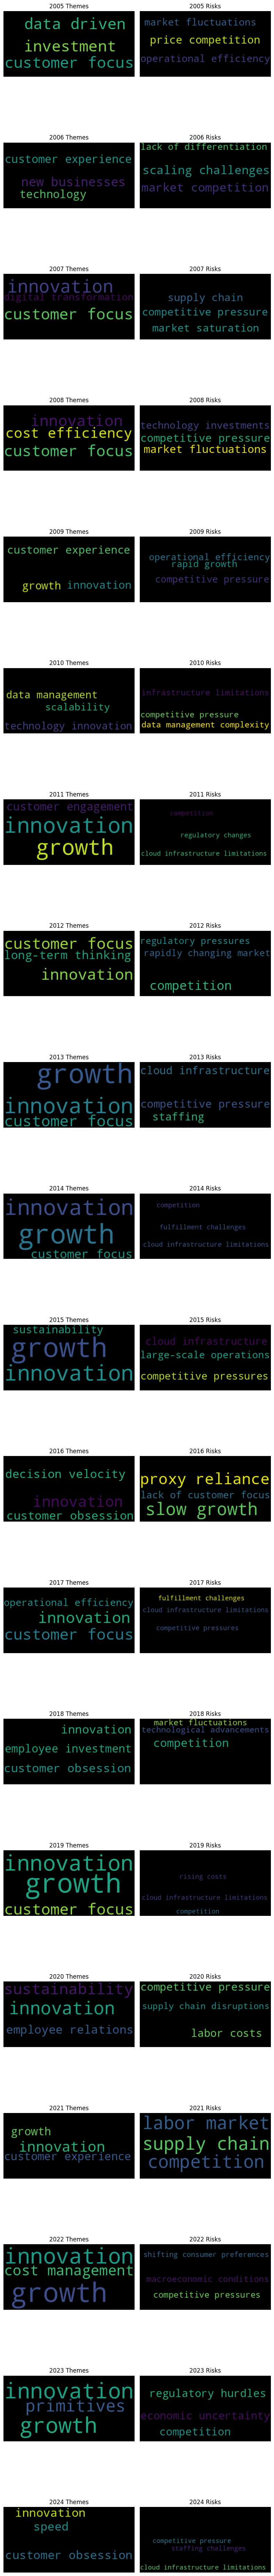

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 1) Define chronological order of years and sort df
year_order = sorted(fs_df["year"].unique())  # Get unique years in ascending order
df_sorted = fs_df.sort_values("year")

# 2) Prepare lists and frequencies for each year
wordcloud_data = []
for year in year_order:
    # Themes frequency
    themes = df_sorted[df_sorted["year"] == year]["themes"].dropna() \
                 .str.split(r",\s*").explode()
    theme_freq = themes.value_counts().to_dict()
    # Risks frequency
    risks = df_sorted[df_sorted["year"] == year]["risks"].dropna() \
                .str.split(r",\s*").explode()
    risk_freq = risks.value_counts().to_dict()
    wordcloud_data.append((year, theme_freq, risk_freq))

# 3) Create subplots: one row per year, 2 columns
fig, axes = plt.subplots(nrows=len(year_order), ncols=2, figsize=(8, 4*len(year_order)))
#fig.suptitle("Yearly Themes and Risks Word Clouds", y=0.92, fontsize=16)

# 4) Generate and plot word clouds
for idx, (year, theme_freq, risk_freq) in enumerate(wordcloud_data):
    # Theme word cloud
    wc_t = WordCloud(width=400, height=200).generate_from_frequencies(theme_freq)
    ax_t = axes[idx, 0]
    ax_t.imshow(wc_t, interpolation="bilinear")
    ax_t.set_title(f"{year} Themes")
    ax_t.axis("off")
    # Risk word cloud
    wc_r = WordCloud(width=400, height=200).generate_from_frequencies(risk_freq)
    ax_r = axes[idx, 1]
    ax_r.imshow(wc_r, interpolation="bilinear")
    ax_r.set_title(f"{year} Risks")
    ax_r.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

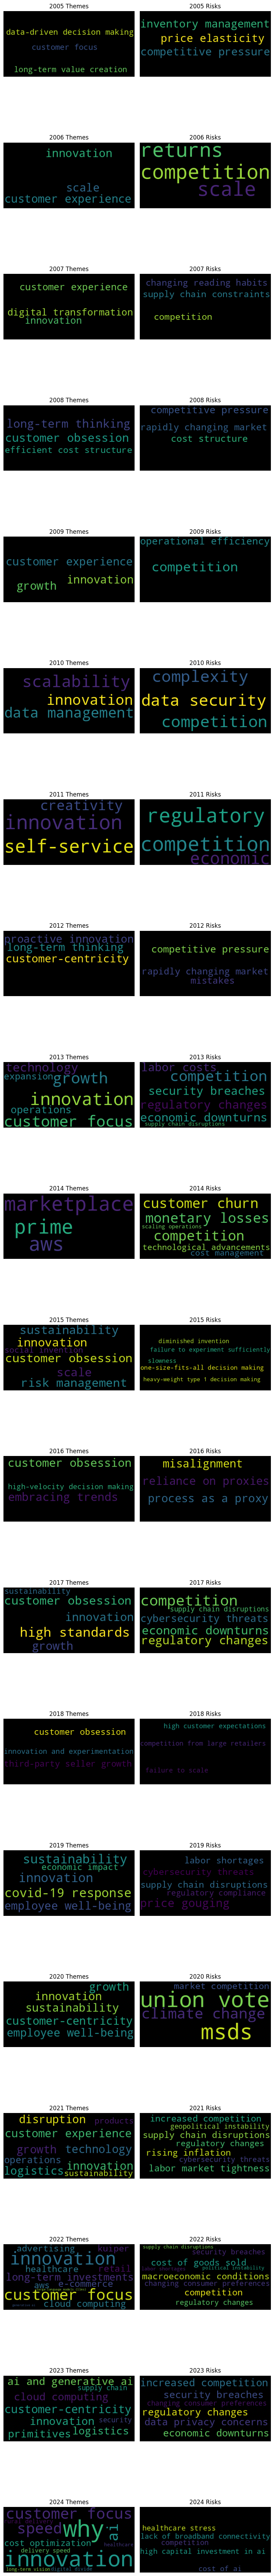

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 1) Define chronological order of years and sort df
year_order = sorted(zs_df["year"].unique())  # Get unique years in ascending order
df_sorted = zs_df.sort_values("year")

# 2) Prepare lists and frequencies for each year
wordcloud_data = []
for year in year_order:
    # Themes frequency
    themes = df_sorted[df_sorted["year"] == year]["themes"].dropna() \
                 .str.split(r",\s*").explode()
    theme_freq = themes.value_counts().to_dict()
    # Risks frequency
    risks = df_sorted[df_sorted["year"] == year]["risks"].dropna() \
                .str.split(r",\s*").explode()
    risk_freq = risks.value_counts().to_dict()
    wordcloud_data.append((year, theme_freq, risk_freq))

# 3) Create subplots: one row per year, 2 columns
fig, axes = plt.subplots(nrows=len(year_order), ncols=2, figsize=(8, 4*len(year_order)))
#fig.suptitle("Yearly Themes and Risks Word Clouds", y=0.92, fontsize=16)

# 4) Generate and plot word clouds
for idx, (year, theme_freq, risk_freq) in enumerate(wordcloud_data):
    # Theme word cloud
    wc_t = WordCloud(width=400, height=200).generate_from_frequencies(theme_freq)
    ax_t = axes[idx, 0]
    ax_t.imshow(wc_t, interpolation="bilinear")
    ax_t.set_title(f"{year} Themes")
    ax_t.axis("off")
    # Risk word cloud
    wc_r = WordCloud(width=400, height=200).generate_from_frequencies(risk_freq)
    ax_r = axes[idx, 1]
    ax_r.imshow(wc_r, interpolation="bilinear")
    ax_r.set_title(f"{year} Risks")
    ax_r.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Sentiment Over Time:

In [ ]:
import pandas as pd
import plotly.express as px

# 1) Load or reference your DataFrame
# If df isn't already loaded, uncomment and adjust the path:
# df = pd.read_csv("/mnt/data/processed_healthcare_reports.csv")

# 2) Map sentiment strings to numeric values
sentiment_map = {"negative": -1, "neutral": 0, "positive": 1}
fs_df["sentiment_score"] = fs_df["sentiment"].str.lower().map(sentiment_map)

# 3) Ensure years are ordered correctly
fs_df = fs_df.sort_values("year")

# 4) Create a Plotly line chart showing sentiment over years
fig = px.line(
    fs_df,
    x="year",
    y="sentiment_score",
    markers=True,
    title="Sentiment Trend Over Time",
    labels={"sentiment_score": "Sentiment Score", "year": "Year"},
)

# 5) Update Y-axis to show discrete labels
fig.update_yaxes(
    tickmode="array",
    tickvals=[-1, 0, 1],
    ticktext=["Negative (-1)", "Neutral (0)", "Positive (1)"]
)

# 6) Show the interactive figure
fig.show()

In [ ]:
import pandas as pd
import plotly.express as px

# 1) Load or reference your DataFrame
# If df isn't already loaded, uncomment and adjust the path:
# df = pd.read_csv("/mnt/data/processed_healthcare_reports.csv")

# 2) Map sentiment strings to numeric values
sentiment_map = {"negative": -1, "neutral": 0, "positive": 1}
zs_df["sentiment_score"] = zs_df["sentiment"].str.lower().map(sentiment_map)

# 3) Ensure years are ordered correctly
zs_df = zs_df.sort_values("year")

# 4) Create a Plotly line chart showing sentiment over years
fig = px.line(
    zs_df,
    x="year",
    y="sentiment_score",
    markers=True,
    title="Sentiment Trend Over Time",
    labels={"sentiment_score": "Sentiment Score", "year": "Year"},
)

# 5) Update Y-axis to show discrete labels
fig.update_yaxes(
    tickmode="array",
    tickvals=[-1, 0, 1],
    ticktext=["Negative (-1)", "Neutral (0)", "Positive (1)"]
)

# 6) Show the interactive figure
fig.show()
